In [ ]:
from pycaret.classification import load_model
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import folium

In [ ]:
df = pd.read_csv("data/seoul_preprocessed.csv")

In [34]:
train_areas = ['강남구', '마포구', '서초구', '영등포구']
train_df = df[df['SIG_KOR_NM'].isin(train_areas)]
test_df = df[~df['SIG_KOR_NM'].isin(train_areas)]


In [37]:
# test를 제외한 데이터로 risk level 추출
df_nonzero = train_df[train_df['tow_count'] > 0]
df_nonzero = df_nonzero[df_nonzero['tow_count'] > 0]

# `tow_count` 값으로 정렬
df_nonzero = df_nonzero.sort_values(by='tow_count')

# 0을 제외한 데이터
total_nonzero = len(df_nonzero)

mid_end = int(total_nonzero*1/2) # 절반

# 각 구간 끝값 (경계)
mid_end_value = df_nonzero.iloc[mid_end - 1]['tow_count']  # 가운데 구간 끝값

print(f"가운데 구간 끝값: {mid_end_value}\n")

test_df['risk_level'] = test_df['tow_count'].apply(
    lambda x: 0 if x == 0 else (1 if x <= mid_end_value else 2)
)

# 결과 확인
print(test_df[['tow_count', 'risk_level']].tail())

가운데 구간 끝값: 2

       tow_count  risk_level
44085          0           0
44086          0           0
44087          0           0
44088          0           0
44089          0           0


In [39]:
features = test_df.columns[3:-2]
target = 'risk_level'
del test_df['tow_count']
X_test, y_test   = test_df[features], test_df[target]

In [ ]:
model4 = load_model('models/domain_specific_model_4')

Transformation Pipeline and Model Successfully Loaded


In [45]:
pred4 = model4.predict(X_test)

In [49]:
f1 = f1_score(y_test, pred4, average ="weighted")
print(f"f1_score: {f1:.4f}")

f1_score: 0.7152


클래스 0


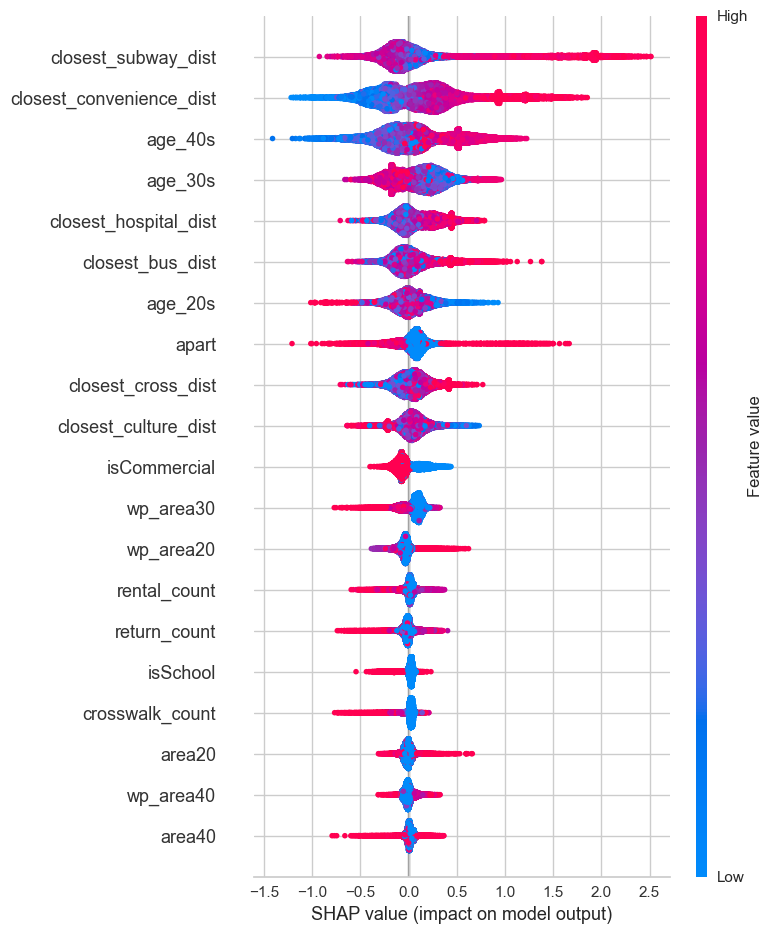

클래스 1


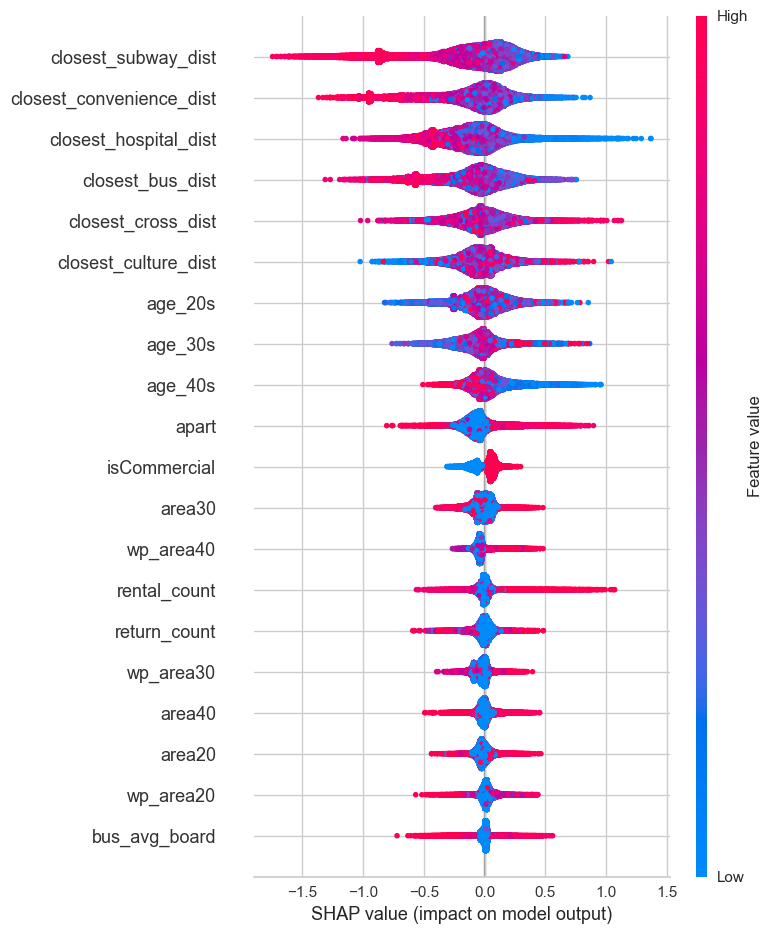

클래스 2


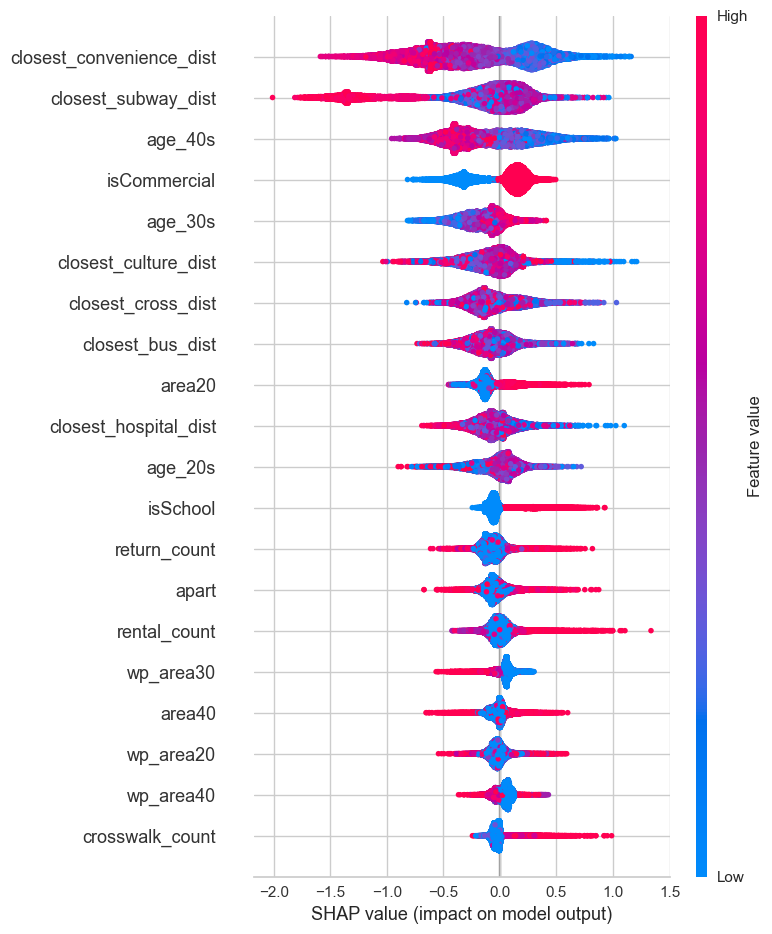

In [98]:
import shap
X_test_transformed = model4[:-1].transform(X_test)

explainer = shap.Explainer(model4.steps[-1][1])
shap_values = explainer(X_test_transformed)

for class_idx in range(shap_values.values.shape[2]):
    print(f"클래스 {class_idx}")
    plt.figure(figsize=(8, 4))
    shap.summary_plot(shap_values.values[:, :, class_idx], X_test_transformed)

In [81]:
test_df['pred'] = pred4

In [ ]:
test_df.to_csv("predictions/final_prediction.csv", index=False)